##Creating the datasets for training and testing from the zip files

In [ ]:
import os
import zipfile, shutil

try:
  shutil.rmtree('train')
except:
  pass
try:
  shutil.rmtree('test')
except:
  pass
try:
  shutil.rmtree('temp')
except:
  pass

with zipfile.ZipFile(input('Train zip: '), 'r') as zip_ref:
    zip_ref.extractall('temp')
    shutil.copytree('temp/'+os.listdir('temp')[0], 'train')
    shutil.rmtree('temp')
with zipfile.ZipFile(input('Test zip: '), 'r') as zip_ref:
    zip_ref.extractall('temp')
    shutil.copytree('temp/'+os.listdir('temp')[0], 'test')
    shutil.rmtree('temp')

Train zip: 1000.zip
Test zip: 500.zip


#Utils

In [ ]:
# Importing libraries and functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
import os
import shutil
import pickle

from keras.preprocessing import image
from sklearn.preprocessing import normalize, LabelEncoder
from skimage.io import imshow
from skimage.feature import local_binary_pattern, hog
from skimage import exposure

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from scipy.stats import skew
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.decomposition import TruncatedSVD
# from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, euclidean

%matplotlib inline

## Feature Extraction

In [ ]:
#slicing the image into 8x8 grids
def slice_channel(channel):
    slices = []
    r = 0
    while r < channel.shape[0]:
        c = 0
        while c < channel.shape[1]:
            channel_slice = channel[r:r + 8, c:c + 8]
            slices.append(channel_slice)
            c = c + 8
        r = r + 8
    return slices

#Calculating color moments: Mean, Standard deviation, Skewness
def ColorMoments(data):
  Outernew = []
  InnerTemp = []
  for each in data:

    each = slice_channel(each)
    
    for ea in each:
      InnerTemp.append([np.mean(ea), np.std(ea), skew(ea.reshape(64))])
    Outernew.append(InnerTemp)
    InnerTemp = []

  colorMoments = np.array(Outernew).reshape((np.array(data).shape[0], 8, 8, 3))
  return colorMoments

def histOrientedGrad(data):
  hog_features=[]
  hog_rescaled=[]
  for img in data:
      fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
      
      hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
      hog_features.append(fd)
      hog_rescaled.append(hog_image_rescaled)

  return np.array(hog_features)

def localBinPattern(data):
  lbp_features = []

  for each in data:
    lbp = local_binary_pattern(each, 8, 1, 'ror')
    hist, edges = np.histogram(lbp, bins = 256, range = (0.0,255.0))
    hist = hist.astype("float")
    hist = hist/(hist.sum() + 1e-7)
    lbp_features.append(hist.tolist())

  return np.array(lbp_features)

## Dimensionality Reduction

In [ ]:
def reduce_dimensions_svd(data_mat, k, get_v=False):
    
    u, s, vt = np.linalg.svd(data_mat, full_matrices=True)
    u = u[:, :k]
    s = s[:k]
    vt = vt[:k, :]
    
    # print(u.shape, s.shape, vt.shape)
    d_reduced = np.matmul(u, np.diag(s))
    if get_v:
        return d_reduced, vt.T
    else:
        return u

def calc_svd(featureVec, k):
  featureVec = np.asarray(featureVec)
  featureVecT = featureVec.transpose()

  Data = featureVec @ featureVecT
  eigen_values_u , eigen_vectors_u = np.linalg.eig(Data)

  DataT = featureVecT @ featureVec
  eigen_values_v , eigen_vectors_v = np.linalg.eig(DataT)

  dim_U, dim_V = len(eigen_vectors_u), len(eigen_vectors_v)
  min_d, max_d = min(dim_U, dim_V), max(dim_U, dim_V)
  zeros = np.zeros(((max_d - min_d), min_d))
  singular_values = eigen_values_u if dim_U < dim_V else eigen_values_v
  for i in range(len(singular_values)):
    if singular_values[i] < 0:
      singular_values[i] = 0
    else:
      continue
  roots = lambda x: np.sqrt(x)
  roots = np.vectorize(roots)
  singular_values = roots(singular_values)

  sorted_index = np.argsort(singular_values)[::-1]
  sorted_singular_values = singular_values[sorted_index]
  sorted_eigen_vectors_u = eigen_vectors_u[:,sorted_index]
  sorted_eigen_vectors_v = eigen_vectors_v[sorted_index, :]
  
  n_components = k 
  eigen_vectors_u_subset = sorted_eigen_vectors_u[:,0:n_components]
  singular_value_subset = sorted_singular_values[:n_components]
  eigen_vectors_v_subset = sorted_eigen_vectors_v[:n_components, :]
  
  
  new_eigen_vectors_u_subset = []

  for i in range(len(eigen_vectors_u_subset)):
    new_eigen_vectors_u_subset.append(eigen_vectors_u_subset[i].real)

  new_eigen_vectors_v_subset = []
  for i in range(len(eigen_vectors_v_subset)):
    new_eigen_vectors_v_subset.append(eigen_vectors_v_subset[i].real)

  return np.asarray(new_eigen_vectors_u_subset), singular_value_subset, np.asarray(new_eigen_vectors_v_subset).T # U, S Vt

## Calculating the metrics

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
# Accuracy: Overall, how often is the classifier correct?
# (TP+TN)/total
# Misclassification Rate: Overall, how often is it wrong?
# (FP+FN)/total
# equivalent to 1 minus Accuracy
# also known as "Error Rate"
# False Positive Rate: When it's actually no, how often does it predict yes?
# FP/actual

def extraa(actual, predicted):
  disp = confusion_matrix(actual, predicted)
  FP = disp.sum(axis=0) - np.diag(disp)  
  FN = disp.sum(axis=1) - np.diag(disp)
  TP = np.diag(disp)
  TN = disp.sum() - (FP + FN + TP)
  
  #Accuracy
  print("Overall accuracy: ", accuracy_score(actual, predicted))
  print('Accuracy: ', (TP+TN)/(TP+TN+FP+FN), '\n')

  #Fall out: False positve rate = FP/FP+TN
  print('False positive rate (Fall out):', FP/(FP+TN), '\n')

  #Miss Rate: False negative rate = FN/FN+TP
  print('False negative rate (Miss rate):', (FP+FN)/(TP+TN+FP+FN), '\n')

  df_cm = pd.DataFrame(disp, index = [i for i in range(disp.shape[1])],
                    columns = [i for i in range(disp.shape[0])])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)

## Balancing the dataset

In [ ]:
import shutil

def balanceOutTheDataset1(folder):
  # os.mkdir('new1'+folder)
  try:
    shutil.rmtree('new1'+folder)
  except:
    pass
  shutil.copytree(folder, 'new1'+folder)

  folder = 'new1'+folder
  classes = set([i.split('-')[1] for i in os.listdir(folder)])

  d = {}
  for i in os.listdir(folder):
    s = i.split('-')[1]
    if s in d.keys():
      d[s] += 1
    else:
      d[s] = 1
  # print("Unbalanced dataset: ", d)

  _ = min(d.values())

  d = {}
  for i in os.listdir(folder):
    s = i.split('-')[1]
    if s in d.keys():
      d[s] += 1
      if d[s]>_:
        os.remove(folder+'/'+i)
    else:
      d[s] = 1

  d={}
  for i in os.listdir(folder):
    s = i.split('-')[1]
    if s in d.keys():
      d[s] += 1
    else:
      d[s] = 1
  # print("Balanced dataset: ", d)

def balanceOutTheDataset2(folder):
  # os.mkdir('new2'+folder)
  try:
    shutil.rmtree('new2'+folder)
  except:
    pass
  shutil.copytree(folder, 'new2'+folder)

  folder = 'new2'+folder
  classes = set([i.split('-')[2] for i in os.listdir(folder)])

  d = {}
  for i in os.listdir(folder):
    s = i.split('-')[2]
    if s in d.keys():
      d[s] += 1
    else:
      d[s] = 1
  # print("Unbalanced dataset: ", d)

  _ = min(d.values())

  d = {}
  for i in os.listdir(folder):
    s = i.split('-')[2]
    if s in d.keys():
      d[s] += 1
      if d[s]>_:
        os.remove(folder+'/'+i)
    else:
      d[s] = 1

  d={}
  for i in os.listdir(folder):
    s = i.split('-')[2]
    if s in d.keys():
      d[s] += 1
    else:
      d[s] = 1
  # print(len(set(d.keys())))
  # print("Balanced dataset: ", d)

def balanceOutTheDataset3(folder):
  # os.mkdir('new3'+folder)
  try:
    shutil.rmtree('new3'+folder)
  except:
    pass
  shutil.copytree(folder, 'new3'+folder)
  
  folder = 'new3'+folder
  classes = set([i.split('-')[3] for i in os.listdir(folder)])

  d = {}
  for i in os.listdir(folder):
    s = i.split('-')[3]
    if s in d.keys():
      d[s] += 1
    else:
      d[s] = 1
  # print("Unbalanced dataset: ", d)

  _ = min(d.values())

  d = {}
  for i in os.listdir(folder):
    s = i.split('-')[3]
    if s in d.keys():
      d[s] += 1
      if d[s]>_:
        os.remove(folder+'/'+i)
    else:
      d[s] = 1

  d={}
  for i in os.listdir(folder):
    s = i.split('-')[3]
    if s in d.keys():
      d[s] += 1
    else:
      d[s] = 1
  # print("Balanced dataset: ", d)

## SVM

In [ ]:
#FLAG
import numpy as np

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder

def projection_simplex(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


class MulticlassSVM(BaseEstimator, ClassifierMixin):

    def __init__(self, C=1, max_iter=50, tol=0.05,
                 random_state=None, verbose=0):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol,
        self.random_state = random_state
        self.verbose = verbose

    def _partial_gradient(self, X, y, i):
        # Partial gradient for the ith sample.
        g = np.dot(X[i], self.coef_.T) + 1
        g[y[i]] -= 1
        return g

    def _violation(self, g, y, i):
        # Optimality violation for the ith sample.
        smallest = np.inf
        for k in range(g.shape[0]):
            if k == y[i] and self.dual_coef_[k, i] >= self.C:
                continue
            elif k != y[i] and self.dual_coef_[k, i] >= 0:
                continue

            smallest = min(smallest, g[k])

        return g.max() - smallest

    def _solve_subproblem(self, g, y, norms, i):
        # Prepare inputs to the projection.
        Ci = np.zeros(g.shape[0])
        Ci[y[i]] = self.C
        beta_hat = norms[i] * (Ci - self.dual_coef_[:, i]) + g / norms[i]
        z = self.C * norms[i]

        # Compute projection onto the simplex.
        beta = projection_simplex(beta_hat, z)

        return Ci - self.dual_coef_[:, i] - beta / norms[i]

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Normalize labels.
        self._label_encoder = LabelEncoder()
        y = self._label_encoder.fit_transform(y)

        # Initialize primal and dual coefficients.
        n_classes = len(self._label_encoder.classes_)
        self.dual_coef_ = np.zeros((n_classes, n_samples), dtype=np.float64)
        self.coef_ = np.zeros((n_classes, n_features))

        # Pre-compute norms.
        norms = np.sqrt(np.sum(X ** 2, axis=1))

        # Shuffle sample indices.
        rs = check_random_state(self.random_state)
        ind = np.arange(n_samples)
        rs.shuffle(ind)

        violation_init = None
        for it in range(self.max_iter):
            violation_sum = 0

            for ii in range(n_samples):
                i = ind[ii]

                # All-zero samples can be safely ignored.
                if norms[i] == 0:
                    continue

                g = self._partial_gradient(X, y, i)
                v = self._violation(g, y, i)
                violation_sum += v

                if v < 1e-12:
                    continue

                # Solve subproblem for the ith sample.
                delta = self._solve_subproblem(g, y, norms, i)

                # Update primal and dual coefficients.
                self.coef_ += (delta * X[i][:, np.newaxis]).T
                self.dual_coef_[:, i] += delta

            if it == 0:
                violation_init = violation_sum

            vratio = violation_sum / violation_init

            # if self.verbose >= 1:
            #     print("iter", it + 1, "violation", vratio)

            if vratio < self.tol:
                # if self.verbose >= 1:
                #     print("Converged")
                break

        return self

    def predict(self, X):
        decision = np.dot(X, self.coef_.T)
        pred = decision.argmax(axis=1)
        return self._label_encoder.inverse_transform(pred)

## Decision Tree
FLAG

In [ ]:
from random import seed
from random import randrange
from csv import reader

# Load a CSV file
def load_csv(filename):
	file = open(filename, "rt")
	lines = reader(file)
	dataset = list(lines)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root

# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
	tree = build_tree(train, max_depth, min_size)
	predictions = list()
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
	return predictions


## PPR

In [ ]:
def find_distance_score(curr_img, data_matrix):
		return np.sqrt(np.sum(np.square(data_matrix - curr_img),axis = 1))

def create_similarity_graph(k, data_matrix, image_ids, function_val):
    img_graph = {}
    for idx in range(data_matrix.shape[0]):
      curr_img = data_matrix[idx]
      curr_img_id = image_ids[idx]
      distance_vector = find_distance_score(curr_img, data_matrix)
      img_distance_map = {x:y for x,y in zip(range(len(image_ids)),distance_vector)}
      if function_val == "cosine":
        img_distance_tuple = sorted(img_distance_map.items(), key = lambda x: x[1], reverse = True)[:k]
      else:
        img_distance_tuple = sorted(img_distance_map.items(), key = lambda x: x[1])[:k]
      img_graph[idx] = [x for x,y in img_distance_tuple]

    return img_graph, image_ids

def get_transition_matrix(outgoing_img_graph, k):
	transition_matrix = [[0 for x in range(len(outgoing_img_graph))] for y in range(len(outgoing_img_graph))]
	for key in outgoing_img_graph:
		for val in outgoing_img_graph[key]:
			transition_matrix[key][val] = 1/k
	return np.array(transition_matrix).T

def get_seed_matrix(label, labels):
    seed_list = []
    count = 0
    # print(label, labels)
    for _ in labels:
        if str(label) == _:
          seed_list.append(1)
        else:
          seed_list.append(0)
    # print(seed_list)
    seed_matrix = np.array(seed_list)
    seed_matrix = seed_matrix/np.sum(seed_matrix)
  
    return seed_matrix

def label_images(temps, unlabeled_image_ids, classes):
    predictions = []
    
    for image in unlabeled_image_ids:
      _ = []
      for i in range(len(temps)):
        _.append((classes[i], temps[i][image]))
      # print(_)
      _ = sorted(_, key=lambda x: x[1])
      # print(_)
      predictions.append((image, _[-1]))

    return predictions

def compute_pagerank(transition_matrix, jump_matrix):
    total_img_count = transition_matrix.shape[0]
    beta = 0.85

    new_pagerank = np.array([1/total_img_count for x in range(total_img_count)])
    old_pagerank = np.array([1/total_img_count for x in range(total_img_count)])

    #print(transition_matrix.shape, old_pagerank.T.shape)

    for x in range(60):
      new_pagerank = beta*np.matmul(transition_matrix,old_pagerank.T) + (1-beta)*jump_matrix.T
      #print(new_pagerank)
      old_pagerank = new_pagerank.T

    
    return new_pagerank

def PPR(data_matrix, labels, k, image_ids, classes, test_image_ids, le):

  function_val = "manhattan"

  #process_all_images(args.train_folder, "CM")
  #process_all_images(args.test_folder, "CM")
  l = len(labels)
  for i in range(data_matrix.shape[0] - l):
    labels = np.append(labels, 'x')

  outgoing_img_graph, image_ids = create_similarity_graph(k, data_matrix, image_ids, function_val)

  transition_matrix = get_transition_matrix(outgoing_img_graph, k)

  temp = []
  for cls in classes:
    seed_matrix_dorsal = get_seed_matrix(cls, labels)
    pagerank = compute_pagerank(transition_matrix, seed_matrix_dorsal)
    
    pagerank_dict = {x:y for x,y in zip(image_ids, pagerank)}

    temp.append(pagerank_dict)
  
  # print('For cc', temp[0])
  predicted = label_images(temp, test_image_ids, classes)
  _ = le.inverse_transform([i[1][0] for i in predicted])

  predicted = [(predicted[i][0], _[i]) for i in range(len(predicted))]
  
  return predicted

#Task 1

Implement a program which,
– given a folder of images, one of the three feature models, and a user specified value of k, computes k latent semantics
(if not already computed and stored), and
– given a second folder of images, associates X labels to the images in the second folder using the classifier selected
by the user:
∗ an SVM classifer,
∗ a decision-tree classifier, or
∗ a PPR based clasifier,
in this latent space.
Also compute and print false positive and miss rates.

In [ ]:
def TASK1(train_folder, model, k, test_folder, classifier):
  #Balancing the dataset
  balanceOutTheDataset1(train_folder)
  train_folder = 'new1'+train_folder
  
  #Image ids = Image names
  images = os.listdir(train_folder)
  image_ids = images

  #Feature extraction using the chosen model by the user
  if model == 'CM':
    model = ColorMoments
  elif model == 'ELBP':
    model = localBinPattern
  elif model == 'HOG':
    model = histOrientedGrad
  else:
    raise ValueError('Choose from these: CM, ELBP, HOG!')

  data = []
  labels = []
  for img in images:
    _ = image.load_img(train_folder+'/'+img, target_size=(64, 64), color_mode='grayscale')
    _ = image.img_to_array(_).reshape((64,64))
    data.append(model([_]).flatten())
    labels.append(img.split('-')[1])

  #Encoding the labels to Integer
  le = LabelEncoder()
  le.fit(labels)
  labels = le.transform(labels)

  #Training data and the labels associated with it
  X = np.array(data)
  labels = np.array(labels).reshape(X.shape[0], 1)

  #Reduced training dataset and the V_matrix
  reduced_data, v_matrix  = reduce_dimensions_svd(X, k, get_v=True)
  
  '''
  dx, ddx, labels, d_labels = train_test_split(reduced_data, labels, test_size = 0.1)
  reduced_data = np.append(dx, ddx, axis = 0)
  labels = np.append(labels, d_labels, axis = 0)
  '''

  #Labeled data for Decision Tree Classifier
  labeled_data = np.append(reduced_data, labels, axis = 1)

  #For the Test dataset
  #images = Image ids of the test dataset
  images = os.listdir(test_folder)
  Y = []
  test_labels = []
  for img in images:
    _ = image.load_img(test_folder+'/'+img, target_size=(64, 64), color_mode='grayscale')
    _ = image.img_to_array(_).reshape((64,64))
    features = model([_]).flatten()
    Y.append(features)
    test_labels.append(img.split('-')[1])

  #Labels extracted from the file names
  Y = np.array(Y)
  
  #Reduced test dataset by projecting on the v_matrix
  reduced_test_dataset = np.matmul(Y, v_matrix)

  #Encoded test dataset labels
  test_labels = le.transform(test_labels)
  test_labels = np.array(test_labels).reshape(Y.shape[0], 1)

  #Labeled test data for Decision Tree Classifier
  labeled_test_data = np.append(reduced_test_dataset, test_labels, axis = 1)
  
  if classifier == 'SVM':
    
    '''
    classifier = SVC(kernel='poly')
    classifier.fit(reduced_data, np.ravel(labels[:]))

    predicted = []
    values = classifier.predict(reduced_test_dataset)
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([label])[0]])
    '''
    #Creating an instance of the SVM class and training on reduced train dataset
    clf = MulticlassSVM(C=0.1, tol=0.01, max_iter=100, random_state=0, verbose=1)
    clf.fit(reduced_data, np.ravel(labels[:]))
    
    #Getting the predictions for the reduced test dataset
    values = clf.predict(reduced_test_dataset)
    predicted = []

    #Associating the test images with the label predicted by our classifier
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([label])[0]])

  elif classifier == 'DT':

    '''
    classifier = DecisionTreeClassifier()
    classifier.fit(reduced_data, labels[:])
    
    predicted = []
    values = classifier.predict(reduced_test_dataset)
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([label])[0]])
    '''

    #Calling the decision tree classifier method for labeled data: [n,k+1]
    values = decision_tree(labeled_data, labeled_test_data, 20, 25)
    predicted = []
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([int(label)])[0]])
    

  elif classifier == 'PPR':

    #Combining the train and test dataset and calling the PPR method on it
    combined_data = np.concatenate((reduced_data, reduced_test_dataset), axis = 0)
    predicted = PPR(combined_data, labels, k, image_ids+images, range(12), images, le)

  else:
    raise ValueError('Choose from these: SVC, DT, PPR!')

  return predicted

#results1 = TASK1('train', 'HOG', 15, 'test', 'PPR')
results1 = TASK1(input('Train folder name: '), input('Feature extraction function: '), int(input('Value of k: ')), input('Test folder name: '), input('Classifier name: '))

Train folder name: train
Feature extraction function: HOG
Value of k: 25
Test folder name: test
Classifier name: SVM


In [ ]:
results1[0:5]

[['image-cc-17-9.png', 'cc'],
 ['image-poster-30-6.png', 'poster'],
 ['image-original-9-6.png', 'original'],
 ['image-emboss-35-4.png', 'emboss'],
 ['image-jitter-30-4.png', 'jitter']]

Overall accuracy:  0.8679245283018868
Accuracy:  [0.98113208 0.97484277 1.         0.98742138 0.92243187 0.97903564
 0.98322851 0.91614256 1.         1.         0.99161426 1.        ] 

False positive rate (Fall out): [0.01576577 0.01395349 0.         0.01382488 0.03464203 0.01587302
 0.00225734 0.04137931 0.         0.         0.00692841 0.        ] 

False negative rate (Miss rate): [0.01886792 0.02515723 0.         0.01257862 0.07756813 0.02096436
 0.01677149 0.08385744 0.         0.         0.00838574 0.        ] 



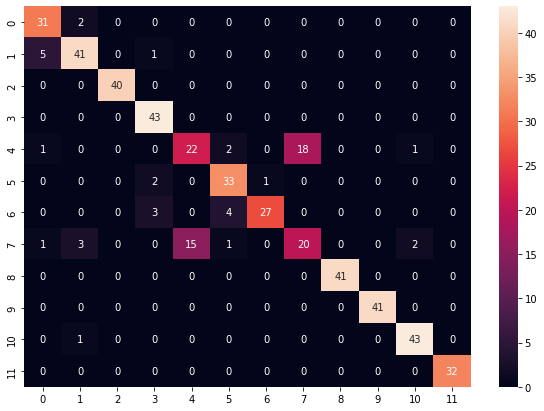

In [ ]:
actual = [i[0].split('-')[1] for i in results1]
predicted = [i[1] for i in results1]
extraa(actual, predicted)

#Task 2
Implement a program which,
– given a folder of images, one of the three feature models, and a user specified value of k, computes k latent semantics
(if not already computed and stored), and
– given a second folder of images, associates Y labels to each image in the second folder using the classifier selected
by the user:
∗ an SVM classifer,
∗ a decision-tree classifier, or
∗ a PPR based clasifier,
in this latent space.
Also compute and print false positive and miss rates.

In [ ]:
def TASK2(train_folder, model, k, test_folder, classifier):
  #Balancing the dataset
  balanceOutTheDataset2(train_folder)
  train_folder = 'new2'+train_folder
  
  #Image ids = Image names
  images = os.listdir(train_folder)
  image_ids = images

  #Feature extraction using the chosen model by the user
  if model == 'CM':
    model = ColorMoments
  elif model == 'ELBP':
    model = localBinPattern
  elif model == 'HOG':
    model = histOrientedGrad
  else:
    raise ValueError('Choose from these: CM, ELBP, HOG!')

  data = []
  labels = []
  for img in images:
    _ = image.load_img(train_folder+'/'+img, target_size=(64, 64), color_mode='grayscale')
    _ = image.img_to_array(_).reshape((64,64))
    data.append(model([_]).flatten())
    labels.append(img.split('-')[2])

  #Encoding the labels to Integer
  le = LabelEncoder()
  le.fit(labels)
  labels = le.transform(labels)

  #Training data and the labels associated with it
  X = np.array(data)
  labels = np.array(labels).reshape(X.shape[0], 1)

  #Reduced training dataset and the V_matrix
  reduced_data, v_matrix  = reduce_dimensions_svd(X, k, get_v=True)
  
  '''
  dx, ddx, labels, d_labels = train_test_split(reduced_data, labels, test_size = 0.1)
  reduced_data = np.append(dx, ddx, axis = 0)
  labels = np.append(labels, d_labels, axis = 0)
  '''

  #Labeled data for Decision Tree Classifier
  labeled_data = np.append(reduced_data, labels, axis = 1)

  #For the Test dataset
  #images = Image ids of the test dataset
  images = os.listdir(test_folder)
  Y = []
  test_labels = []
  for img in images:
    _ = image.load_img(test_folder+'/'+img, target_size=(64, 64), color_mode='grayscale')
    _ = image.img_to_array(_).reshape((64,64))
    features = model([_]).flatten()
    Y.append(features)
    test_labels.append(img.split('-')[2])

  #Labels extracted from the file names
  Y = np.array(Y)
  
  #Reduced test dataset by projecting on the v_matrix
  reduced_test_dataset = np.matmul(Y, v_matrix)

  #Encoded test dataset labels
  test_labels = le.transform(test_labels)
  test_labels = np.array(test_labels).reshape(Y.shape[0], 1)

  #Labeled test data for Decision Tree Classifier
  labeled_test_data = np.append(reduced_test_dataset, test_labels, axis = 1)
  
  if classifier == 'SVM':
    
    '''
    classifier = SVC(kernel='poly')
    classifier.fit(reduced_data, np.ravel(labels[:]))

    predicted = []
    values = classifier.predict(reduced_test_dataset)
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([label])[0]])
    '''
    #Creating an instance of the SVM class and training on reduced train dataset
    clf = MulticlassSVM(C=0.1, tol=0.01, max_iter=100, random_state=0, verbose=1)
    clf.fit(reduced_data, np.ravel(labels[:]))
    
    #Getting the predictions for the reduced test dataset
    values = clf.predict(reduced_test_dataset)
    predicted = []

    #Associating the test images with the label predicted by our classifier
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([label])[0]])

  elif classifier == 'DT':

    '''
    classifier = DecisionTreeClassifier()
    classifier.fit(reduced_data, labels[:])
    
    predicted = []
    values = classifier.predict(reduced_test_dataset)
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([label])[0]])
    '''

    #Calling the decision tree classifier method for labeled data: [n,k+1]
    values = decision_tree(labeled_data, labeled_test_data, 20, 25)
    predicted = []
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([int(label)])[0]])
    

  elif classifier == 'PPR':

    #Combining the train and test dataset and calling the PPR method on it
    combined_data = np.concatenate((reduced_data, reduced_test_dataset), axis = 0)
    predicted = PPR(combined_data, labels, k, image_ids+images, range(40), images, le)

  else:
    raise ValueError('Choose from these: SVC, DT, PPR!')

  return predicted

results2 = TASK2(input('Train folder name: '), input('Feature extraction function: '), int(input('Value of k: ')), input('Test folder name: '), input('Classifier name: '))
#results2 = TASK2('train', 'CM', 30, 'test', 'PPR')

Train folder name: train
Feature extraction function: HOG
Value of k: 25
Test folder name: test
Classifier name: SVM


In [ ]:
results2[:5]

[['image-cc-17-9.png', '16'],
 ['image-poster-30-6.png', '38'],
 ['image-original-9-6.png', '9'],
 ['image-emboss-35-4.png', '33'],
 ['image-jitter-30-4.png', '5']]

Overall accuracy:  0.48427672955974843
Accuracy:  [0.95807128 0.97274633 0.97903564 0.9706499  0.99161426 0.98113208
 0.98532495 0.97484277 0.9706499  0.96226415 0.96855346 0.98951782
 0.98742138 0.96016771 0.97903564 0.99161426 0.9706499  0.97274633
 0.9706499  0.95807128 0.97903564 0.97274633 0.99371069 0.98532495
 0.97274633 0.98322851 0.97484277 0.98113208 0.96016771 0.98322851
 0.95807128 0.98113208 0.95807128 0.96436059 0.95807128 0.97484277
 0.9769392  0.96226415 0.97484277 0.97903564] 

False positive rate (Fall out): [0.02832244 0.01284797 0.01290323 0.01290323 0.00212766 0.00860215
 0.00639659 0.01079914 0.00217391 0.01505376 0.02141328 0.00215054
 0.00211864 0.01935484 0.00433839 0.         0.01935484 0.02365591
 0.01709402 0.03205128 0.01293103 0.00863931 0.         0.0042735
 0.01082251 0.01084599 0.01077586 0.00643777 0.01943844 0.00215983
 0.0385439  0.01282051 0.02178649 0.02365591 0.01301518 0.0193133
 0.01077586 0.0237581  0.0172043  0.00860215] 

False negative rate 

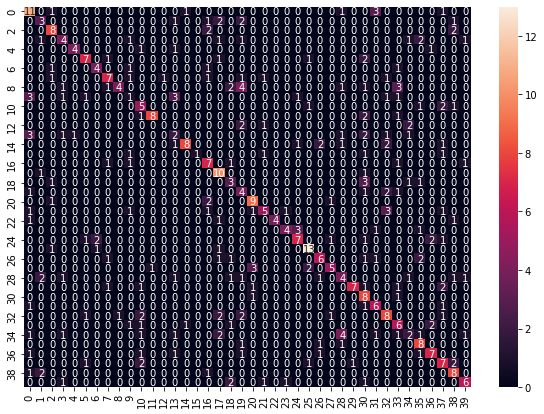

In [ ]:
actual = [i[0].split('-')[2] for i in results2]
predicted = [i[1] for i in results2]
extraa(actual, predicted)

#Task 3
Implement a program which,
– given a folder of images, one of the three feature models, and a user specified value of k, computes k latent semantics
(if not already computed and stored), and
– given a second folder of images, associates Z labels to each image in the second folder using the classifier selected
by the user:
∗ an SVM classifer,
∗ a decision-tree classifier, or
∗ a PPR based clasifier,
in this latent space.
Also compute and print false positive and miss rates.

In [ ]:
def TASK3(train_folder, model, k, test_folder, classifier):
  #Balancing the dataset
  balanceOutTheDataset3(train_folder)
  train_folder = 'new3'+train_folder

  #Image ids = Image names
  images = os.listdir(train_folder)
  image_ids = images

  #Feature extraction using the chosen model by the user
  if model == 'CM':
    model = ColorMoments
  elif model == 'ELBP':
    model = localBinPattern
  elif model == 'HOG':
    model = histOrientedGrad
  else:
    raise ValueError('Choose from these: CM, ELBP, HOG!')

  data = []
  labels = []
  for img in images:
    _ = image.load_img(train_folder+'/'+img, target_size=(64, 64), color_mode='grayscale')
    _ = image.img_to_array(_).reshape((64,64))
    data.append(model([_]).flatten())
    labels.append(img.split('-')[3])

  #Encoding the labels to Integer
  le3 = LabelEncoder()
  le3.fit(labels)
  labels = le3.transform(labels)

  #Training data and the labels associated with it
  X = np.array(data)
  labels = np.array(labels).reshape(X.shape[0], 1)

  #Reduced training dataset and the V_matrix
  reduced_data, v_matrix  = reduce_dimensions_svd(X, k, get_v = True)

  #Labeled data for Decision Tree Classifier
  labeled_data = np.append(reduced_data, labels, axis = 1)

  #For test dataset
  images = os.listdir(test_folder)
  dict_array = []
  test_labels = []
  for img in images:
    _ = image.load_img(test_folder+'/'+img, target_size=(64, 64), color_mode='grayscale')
    _ = image.img_to_array(_).reshape((64,64))
    features = model([_]).flatten()
    dict_array.append(features)
    test_labels.append(img.split('-')[3])
  Y = np.array(dict_array)

  #Reduced test dataset by projecting on the v_matrix
  reduced_test_dataset = np.matmul(Y, v_matrix)

  #Encoded test dataset labels
  test_labels = le3.transform(test_labels)
  test_labels = np.array(test_labels).reshape(Y.shape[0], 1)

  #Labeled test data for Decision Tree Classifier
  labeled_test_data = np.append(reduced_test_dataset, test_labels, axis = 1)

  if classifier == 'SVM':
    
    '''
    classifier = SVC(kernel='poly')
    classifier.fit(reduced_data, np.ravel(labels[:]))

    predicted = []
    values = classifier.predict(reduced_test_dataset)
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([label])[0]])
    '''
    #Creating an instance of the SVM class and training on reduced train dataset
    clf = MulticlassSVM(C=0.1, tol=0.01, max_iter=100, random_state=0, verbose=1)
    clf.fit(reduced_data, np.ravel(labels[:]))
    
    #Getting the predictions for the reduced test dataset
    values = clf.predict(reduced_test_dataset)
    predicted = []

    #Associating the test images with the label predicted by our classifier
    for img, label in zip(images, values):
      predicted.append([img, le3.inverse_transform([label])[0]])
  
  elif classifier == 'DT':

    '''
    classifier = DecisionTreeClassifier()
    classifier.fit(reduced_data, labels[:])
    
    predicted = []
    values = classifier.predict(reduced_test_dataset)
    for img, label in zip(images, values):
      predicted.append([img, le.inverse_transform([label])[0]])
    '''

    #Calling the decision tree classifier method for labeled data: [n,k+1]
    values = decision_tree(labeled_data, labeled_test_data, 20, 25)
    predicted = []
    for img, label in zip(images, values):
      predicted.append([img, le3.inverse_transform([int(label)])[0]])
  
  elif classifier == 'PPR':
    #Combining the train and test dataset and calling the PPR method on it
    combined_data = np.concatenate((reduced_data, reduced_test_dataset), axis = 0)
    predicted = PPR(combined_data, labels, k, image_ids+images, range(10), images, le3)
  
  else:
    raise ValueError('Choose from these: SVM, DT, PPR!')

  return predicted

results3 = TASK3(input('Train folder name: '), input('Feature extraction function: '), int(input('Value of k: ')), input('Test folder name: '), input('Classifier name: '))
#results3 = TASK3('train', 'HOG', 25, 'test', 'DT')

Train folder name: train
Feature extraction function: CM
Value of k: 25
Test folder name: test
Classifier name: PPR


In [ ]:
results3[:5]

[('image-cc-17-9.png', '5.png'),
 ('image-poster-30-6.png', '2.png'),
 ('image-original-9-6.png', '8.png'),
 ('image-emboss-35-4.png', '4.png'),
 ('image-jitter-30-4.png', '4.png')]

Overall accuracy:  0.1509433962264151
Accuracy:  [0.8490566  0.85115304 0.81761006 0.8197065  0.76310273 0.87421384
 0.84696017 0.84486373 0.77148847 0.86373166] 

False positive rate (Fall out): [0.06960557 0.05841121 0.11520737 0.10046729 0.17061611 0.05517241
 0.08878505 0.07192575 0.16083916 0.05386417] 

False negative rate (Miss rate): [0.1509434  0.14884696 0.18238994 0.1802935  0.23689727 0.12578616
 0.15303983 0.15513627 0.22851153 0.13626834] 



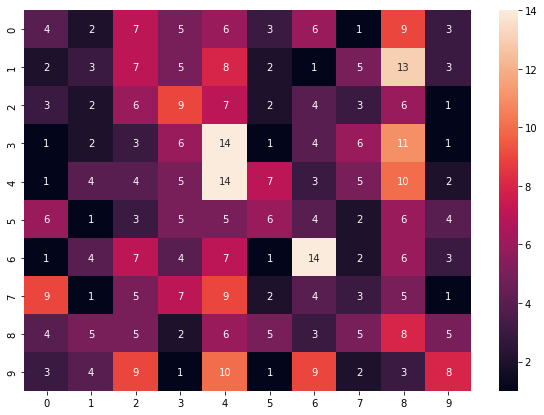

In [ ]:
actual = [i[0].split('-')[3] for i in results3]
predicted = [i[1] for i in results3]
extraa(actual, predicted)

#Task 4
– Implement a Locality Sensitive Hashing (LSH) tool, which takes as input (a) the number of layers, L, (b) the number
of hashes per layer, κ, and (c) a set of vectors (generated by other tasks) as input and creates an in-memory index
structure containing the given set of vectors. See
”Near-Optimal Hashing Algorithms for Approximate Nearest Neighbor in High Dimensions” (by Alexandr
Andoni and Piotr Indyk). Communications of the ACM, vol. 51, no. 1, 2008, pp. 117-122.
– Implement similar image search using this index structure:
∗ given a folder of images and one of the three feature models, the images are stored in an LSH data structure
(the program also outputs the size of the index structure in bytes), and
∗ given image and t, the tool outputs the t most similar images; it also outputs
· the numbers of buckets searched as well as the unique and overall number of images considered
· false positive and miss rates.


##Plot util

In [ ]:
def plot_results_task4(similar_images, query_image_path):
    
    #Getting the length of the similar images 
    k = len(similar_images)

    #Displaying 'k' similar images using the matplotlib library
    nrows = int(np.sqrt(k)) + 1
    ncols = int(np.ceil(k/nrows))

    if nrows * ncols <= k:
        ncols += 1
    
    f, s_arr = plt.subplots(nrows, ncols, figsize=(10,10))
    s_arr[0][0].axis("off")
    s_arr[0][0].text(0.5,-0.1, "Target Image", size=10, ha="center", transform=s_arr[0][0].transAxes)
    s_arr[0][0].imshow(plt.imread(query_image_path))
    i,j = 0,1
    for x in similar_images:
        if k <= 0:
            break
        s_arr[i][j].axis("off")
        s_arr[i][j].text(0.5,-0.1,x["imageName"], size=10, ha="center", transform=s_arr[i][j].transAxes)
        s_arr[i][j].imshow(plt.imread(x["image_path"]))
        j += 1
        if j >= ncols:
            j = 0
            i += 1
        k -= 1
    while i < nrows:
        while j < ncols:
            s_arr[i][j].axis("off")
            j += 1
        i += 1
        j = 0
    
   
    plt.show()

##LSH Class

In [ ]:
import json
import math
import os
import random
import numpy
import pandas as pd
from scipy.spatial import distance

class ImageLocalSensitiveHashing():
    def __init__(self, num_layers, num_hashs):
        print("Initializing LSH index with {0} Layers and {1} Hashes".format(num_layers, num_hashs))
        self.num_layers = num_layers
        self.num_hashs = num_hashs
        self.latent_range_dict = {}
        self.lsh_points_dict = {}
        self.lsh_range_dict = {}
        self.image_bucket_df = pd.DataFrame()
        self.image_latent_df = pd.DataFrame()
        self.w_length = 0.0

    def load_data(self, data_matrix, image_ids):

        #Loading the data matrix
        self.data_matrix, self.image_ids = data_matrix, image_ids
        self.reduced_data = self.data_matrix
        return self.reduced_data, self.image_ids

    def projectOnHashFunction(self, lsh_vector, image_vector):

        #Projecting image vector on the hash function
        image_lsh_dot_product = numpy.dot(image_vector, lsh_vector)
        if image_lsh_dot_product == 0.0:
            return 0
        lsh_vector_dot_product = numpy.dot(lsh_vector, lsh_vector)
        projection = image_lsh_dot_product/lsh_vector_dot_product*lsh_vector
        projection_magnitude = numpy.linalg.norm(projection)
        return projection_magnitude


    def LSH(self, vector):

        #List of buckets for the input vector
        bucket_list = []
        for lsh_vector in range(0, len(self.lsh_points_dict)):
            
            value = self.projectOnHashFunction(numpy.array(self.lsh_points_dict[lsh_vector]), numpy.array(vector))
            #Assign bucket
            if value < 0: 
              _ = math.floor(value/self.w_length)
            else:
              _ = math.ceil(value / self.w_length)                 
            bucket_list.append(_)

        return bucket_list

    def groupingdata(self):

        #Grouping all images into the buckets
        print("Grouping data into buckets")
        reduced_df = pd.DataFrame(self.reduced_data)
        print(reduced_df)
        
        # Intializing the LSH vectors
        # First finds range for each column in the df. It then finds uniform distributions of the range for each column
        # That is assigned to each lsh point
        # The lsh distance from 0 vector to the lsh points list is found

        print("Initializing the LSH vectors")
        origin = list(numpy.zeros(shape=(1, 256)))
        for column in reduced_df:
            self.latent_range_dict[column] = (reduced_df[column].min(), reduced_df[column].max())

        for i in range(0, self.num_layers * self.num_hashs):
            cur_vector_list = []
            for column in reduced_df:
                cur_vector_list.append(random.uniform(self.latent_range_dict[column][0], self.latent_range_dict[column][1]))
            self.lsh_points_dict[i] = cur_vector_list
            
            self.lsh_range_dict[i] = distance.euclidean(origin, cur_vector_list)
        #Intializing finished the LSH vectors

        #Computing the window length
        self.w_length = min(self.lsh_range_dict.values()) / float(100)

        #Initializing the Bucket matrix
        bucket_matrix = numpy.zeros(shape=(len(self.reduced_data), len(self.lsh_points_dict)))
        #The shape is number of samples in U * (L * k)

        #Updating the bucket_matrix
        for image in range(0, len(self.reduced_data)):
            bucket_matrix[image] = self.LSH(self.reduced_data[image])

        #
        image_id_df = pd.DataFrame(self.image_ids, columns=['image_id'])
        self.image_latent_df = reduced_df.join(image_id_df, how="left")
        return pd.DataFrame(bucket_matrix).join(image_id_df, how="left")

    def indexingdata(self):
        
        #Assigning buckets to images in the dataframe
        print("Indexing the structure..")
        indexstructure_dict = {}
        counterval = 0
        for index, row in self.image_bucket_df.iterrows():
            image_id = row["image_id"]
            column = 0
            for i in range(0, self.num_layers):
                bucket = ""
                for j in range(0, self.num_hashs):
                    interval = row[column]
                    bucket = bucket + str(int(interval)) + "-"
                    column += 1
                    if bucket.strip("-") in indexstructure_dict:
                        indexstructure_dict[bucket.strip("-")].add(image_id)
                    else:
                        image_set = set()
                        image_set.add(image_id)
                        indexstructure_dict[bucket.strip("-")] = image_set

        return indexstructure_dict

    def fetch_hash_keys(self, bucket_list):
        
        #Obtain the hash keys for the bucket list
        column = 0
        hash_key_list = []
        for i in range(0, self.num_layers):
            bucket = ""
            for j in range(0, self.num_hashs):
                interval = bucket_list[column]
                if(j != self.num_hashs - 1):
                    bucket = bucket + str(int(interval)) + "-"
                else:
                    bucket = bucket + str(int(interval))
                column += 1
            hash_key_list.append(bucket)
        return hash_key_list

    def create_index_structure(self):

        #Creates index structure for search
        #This comprises the bucketed data and the image id on the right most column
        self.image_bucket_df = self.groupingdata()
        self.index_structure = self.indexingdata()
        return self.index_structure, self.lsh_points_dict

    def load_index_structure(self, idx, points_dict, w_length):

        #Loading the index structure
        self.index_structure = idx
        self.lsh_points_dict = points_dict
        self.w_length = w_length

    def find_similar_images(self, query_vector, no_of_images, reduced_dict):

        #Nearest neighbor for the query vector
        query_bucket_list = self.LSH(query_vector)

        query_hash_key_list = self.fetch_hash_keys(query_bucket_list)
        query_hash_key_list = list(set(query_hash_key_list))

        print("Hash Key List {0}".format(query_hash_key_list))
        selected_image_set = set()
        nearest_neighbour_list = set()
        total_images_considered = []
        
        #Finding the similar images given in the query vector
        for j in range(0, self.num_hashs):
            for bucket in query_hash_key_list:
                print("Getting bucket - {0}".format(bucket.rsplit("-", j)[0]))
                images_in_current_bucket = self.index_structure.get(bucket.rsplit("-", j)[0], [''])

                images_in_current_bucket = set(images_in_current_bucket)
                images_in_current_bucket.discard('')
                selected_image_set.update(images_in_current_bucket)
                total_images_considered.extend(list(images_in_current_bucket))
                feature_vectors = []

                for img in selected_image_set:
                    feature_vectors.append(reduced_dict[img])
                  
                for img, fv in zip(selected_image_set, feature_vectors):
                    
                    eucledian_distance = distance.euclidean(fv, query_vector)
                    if (eucledian_distance != 0):
                        nearest_neighbour_list.add((img, eucledian_distance))

       
        nearest_neighbour_list = sorted(nearest_neighbour_list, key=lambda x: x[1])

        return nearest_neighbour_list[:no_of_images], len(nearest_neighbour_list),len(total_images_considered)

##Task 4a

In [ ]:
import json

def Task4a(L, k, train_folder, model):
    #Balancing the dataset first
    balanceOutTheDataset1(train_folder)
    train_folder = 'new1'+train_folder

    #Image ids = image names of the train folder
    images = os.listdir(train_folder)
    image_ids = images

    #Feature extraction using the three models
    if model == 'CM':
      model = ColorMoments
    elif model == 'ELBP':
      model = localBinPattern
    elif model == 'HOG':
      model = histOrientedGrad
    else:
      raise ValueError('Choose from these: CM, ELBP, HOG!')

    #Reading the images from the folder and storing the features extracted
    data = []
    image_features = {}
    c = 0
    for img in images:
      _ = image.load_img(train_folder+'/'+img, target_size=(64, 64), color_mode='grayscale')
      _ = image.img_to_array(_).reshape((64,64))
      feats = model([_]).flatten()
      data.append(feats)
      #Associating the image numbers in image features dictionary
      image_features[img] = c
      c += 1
  
    X = np.array(data)
    
    #Dimensionality reduction on the data matrix of shape (?,?) to shape (?, 256)
    reduced_data, v_matrix  = reduce_dimensions_svd(X, 256, get_v = True)
    
    reduced_dict = {}
    for i in range(len(images)):
      reduced_dict[images[i]] = reduced_data[i]

    #Local Sensitive Hashing
    lsh = ImageLocalSensitiveHashing(L, k)
    #Loading our data to the LSH object
    reduced_data, image_ids = lsh.load_data(reduced_data, image_ids)

    #Creating the index structure
    idx_structure, points_dict = lsh.create_index_structure()

    #Storing the values in index structure
    for key, val in idx_structure.items():
        idx_structure[key] = list(val)

    #Storing the LSH points
    lsh_points = {}
    for key, val in points_dict.items():
        lsh_points[str(key)] = val


    idx_structure['_id'] = "index"
    lsh_points['_id'] = "points"
    
    #Window length
    w_length = { '_id' : "w_length", "w_length" : lsh.w_length }

    #Storing the number of layers and number of hashes as the config dictionary
    config  = { 'k' : k, 'L': L}

    #Storing our structure as a .json file
    with open('index.json', 'w') as fp:
        json.dump(idx_structure, fp)
    
    print("Idx Structure: ", idx_structure)
    print("lsh points: ", lsh_points)

    #Returning the important terms of the Task A
    return points_dict, w_length, config, train_folder, image_features, reduced_data, reduced_dict, v_matrix

#points_dict, w_length, config, train_folder, image_features, reduced_data, reduced_dict, v_matrix = Task4a(10, 5, 'train', 'HOG')
points_dict, w_length, config, train_folder, image_features, reduced_data, reduced_dict, v_matrix = Task4a(int(input('Number of Layers: ')), int(input('Number of Hashes: ')), input("Train folder: "), "HOG")

Number of Layers: 15
Number of Hashes: 10
Train folder: train
Initializing LSH index with 15 Layers and 10 Hashes
Grouping data into buckets
          0         1         2    ...       253       254       255
0   -6.163162  0.358957  0.263837  ...  0.011600 -0.091758  0.098492
1   -6.148445  0.710235  0.739198  ... -0.092085  0.015751  0.291075
2   -5.139398  0.564551  2.231425  ...  0.016288  0.127344 -0.059825
3   -5.014546 -3.704459  0.550343  ... -0.027033  0.095299 -0.109770
4   -5.960274  0.880382  0.311147  ...  0.015702  0.029196 -0.011018
..        ...       ...       ...  ...       ...       ...       ...
775 -5.703477  1.093711 -0.637188  ...  0.011840 -0.047130  0.069961
776 -6.033749  0.382763  0.371418  ... -0.112693 -0.021246  0.028218
777 -5.950293  0.351760  0.839996  ... -0.070365  0.277328 -0.017291
778 -5.755367  1.107785  0.228097  ...  0.126667  0.056647  0.220757
779 -5.189057 -3.973678 -1.035312  ...  0.086930 -0.049035 -0.052489

[780 rows x 256 columns]
Initi

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##Task 4b

In [ ]:
def Task4b(t, query_image_id, points_dict, w_length, config, train_folder,image_features, reduced_data, reduced_dict, v_matrix):
    
    #Reading the index structure
    with open('index.json', 'r') as fp:
        idx_structure = json.load(fp)

    #Reading the points_dict from Task4b for creating lsh_points
    lsh_points = {}
    for k, v in points_dict.items():
        lsh_points[int(k)] = v

    #Reading the query image and calculating the features and 
    #applying the dimensionality reduction technique on it
    _ = image.load_img('test'+'/'+query_image_id, target_size=(64, 64), color_mode='grayscale')
    _ = image.img_to_array(_).reshape((64,64))
    _ = histOrientedGrad([_]).flatten()
    query_vector = np.matmul(_, v_matrix)

    #Generating the object for LSH
    lsh = ImageLocalSensitiveHashing(config["k"], config["L"])
    #Loading the index structure generated in the previous task
    lsh.load_index_structure(idx_structure, lsh_points, w_length['w_length'])
    #Finding the most similar images from the input images and t
    similarity_scores, total_images_considered, unique_images_considered  = lsh.find_similar_images(query_vector, t, reduced_dict)

    #Storing the similar images and names and the distances
    similar_images = []
    for score in similarity_scores:
        imag = {}
        imag["distance_score"] = score[1]
        imag["imageName"] = score[0]
        imag["image_path"] = 'train/' + score[0]
        imag["feature_vector"] = reduced_dict[score[0]]
        similar_images.append(imag)

    print("Number of unique images considered = {0}".format(total_images_considered))
    print("Number of overall Images considerd = {0}".format(unique_images_considered))

    #Plotting the similar image results
    # plot_results_task4(similar_images, 'test/'+query_image_id)

    return similar_images, query_image_id

# similar_images, query_image_id = Task4b(20, 'image-emboss-1-2.png', points_dict, w_length, config, train_folder, image_features, reduced_data, reduced_dict, v_matrix)
query_image_id = input('Query image name from the test folder: ')
similar_images, query_image_id = Task4b(int(input('Number of most similar images (t): ')), query_image_id, points_dict, w_length, config, train_folder, image_features, reduced_data, reduced_dict, v_matrix)

Query image name from the test folder: image-cc-1-1.png
Number of most similar images (t): 20
Initializing LSH index with 10 Layers and 15 Hashes
Hash Key List ['41-50-52-46-47-46-46-48-40-51-40-52-40-48-40', '46-41-54-55-44-45-51-43-40-45-51-44-45-47-47', '36-48-47-49-41-57-58-45-40-48-45-56-41-49-46', '52-50-47-51-41-35-51-50-40-46-44-44-51-52-43', '44-35-53-53-51-30-45-50-38-49-53-36-48-42-50', '46-51-51-62-50-29-43-34-47-44-48-51-59-46-44', '31-47-51-50-46-49-53-49-47-26-39-36-47-55-41', '47-53-46-47-51-47-48-45-38-56-40-42-49-49-41', '48-56-50-45-41-46-55-55-51-55-55-43-52-56-44', '40-53-40-51-36-42-44-49-54-37-51-47-43-39-42']
Getting bucket - 41-50-52-46-47-46-46-48-40-51-40-52-40-48-40
Getting bucket - 46-41-54-55-44-45-51-43-40-45-51-44-45-47-47
Getting bucket - 36-48-47-49-41-57-58-45-40-48-45-56-41-49-46
Getting bucket - 52-50-47-51-41-35-51-50-40-46-44-44-51-52-43
Getting bucket - 44-35-53-53-51-30-45-50-38-49-53-36-48-42-50
Getting bucket - 46-51-51-62-50-29-43-34-47-44-48

In [ ]:
[(i['imageName'], i['distance_score']) for i in similar_images[:3]]

[('image-cc-1-1.png', 6.157374458430043e-14),
 ('image-cc-24-1.png', 3.7773874864466372),
 ('image-emboss-1-1.png', 3.781218029859273)]

In [ ]:
similar_images[0]

{'distance_score': 6.157374458430043e-14,
 'feature_vector': array([-6.07454400e+00,  1.30734554e-01,  8.87524590e-01, -1.29170697e+00,
        -4.23453044e-01,  2.01972588e-01, -4.99006582e-01,  8.53844361e-02,
         4.26126973e-01, -6.83230299e-03, -1.29187881e-02,  4.79670103e-03,
         2.91681029e-01,  2.73882221e-01,  2.56222805e-01, -7.29617379e-01,
         1.29922575e-01, -1.79710683e-02, -9.45426646e-02, -1.53644589e-01,
        -1.04676679e-01,  3.78060549e-02, -2.41906460e-01, -1.17257137e-01,
        -3.49923456e-01, -5.61802520e-01, -3.27328464e-01,  2.80235514e-01,
        -3.46389994e-02,  2.09894543e-01,  1.31874192e-02,  7.16846143e-04,
        -1.11838961e-01,  5.08439133e-02, -3.26929504e-01, -1.18725705e-02,
         2.99897223e-01,  1.84821138e-01, -3.59549302e-02, -1.17857030e-01,
         1.33840694e-01, -9.07573732e-02,  2.01324950e-01,  4.07405308e-01,
        -2.37041101e-02, -1.95997966e-01, -1.89227196e-01,  1.91100565e-01,
         2.12343161e-01,  1.

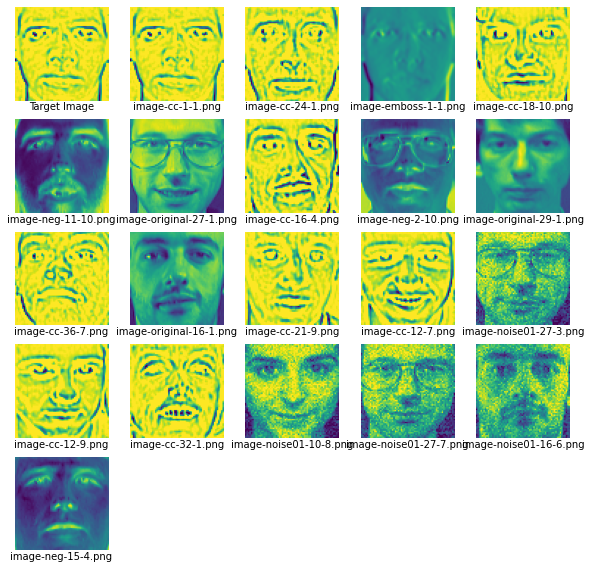

In [ ]:
plot_results_task4(similar_images, 'test/'+query_image_id)

Accuracy for X:  0.45
Misses for X:  11
Overall accuracy:  0.45
Accuracy:  [0.45 0.45] 

False positive rate (Fall out): [0.55  nan] 

False negative rate (Miss rate): [0.55 0.55] 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


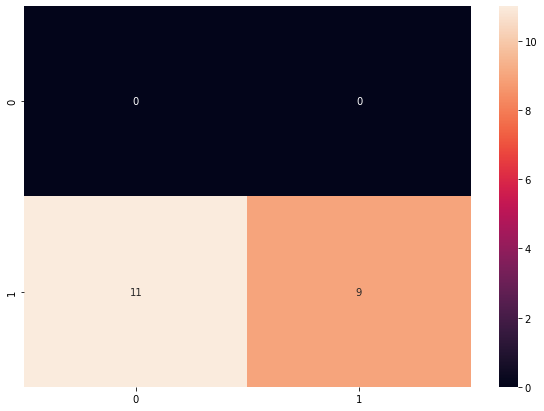

In [ ]:
actual = [1] * len(similar_images)
predicted = []
for similar_image in similar_images:
  if (similar_image['imageName'].split('-')[1] == query_image_id.split('-')[1]):
    predicted.append(1)
  else:
    predicted.append(0)

print("Accuracy for X: ", predicted.count(1)/len(predicted))
print("Misses for X: ", predicted.count(0))

extraa(actual, predicted)

#Task 5
Given (a) a parameter b denoting the number of bits per dimensions used for compressing the vector data and (b) a
set of vectors (generated by other tasks) as input, the program and creates an in-memory index structure containing
the indexes of the given set of vectors. The program also outputs the size of the index structure in bytes.
– Implement similar image search using this index structure:
∗ given a folder of images and one of the three feature models, the images are stored in a VA-file data structure
(the program also outputs the size of the index structure in bytes), and
∗ given image and t, the tool outputs the t most similar images; it also outputs
· the numbers of buckets searched as well as the unique and overall number of images considered
· false positive and miss rates.

##Plot util

In [ ]:
def plot_results_task5(similar_images, query_image_path):
    k = len(similar_images)
    # this part is for displaying 'k' similar images using matplotlib library
    rows = int(np.sqrt(k)) + 1
    cols = int(np.ceil(k/rows))
    if rows * cols <= k:
        cols += 1
    # fig = plt.figure()
    f, s_arr = plt.subplots(rows, cols, figsize=(10,10))
    s_arr[0][0].axis("off")
    s_arr[0][0].text(0.5,-0.1, "Target Image", size=10, ha="center", transform=s_arr[0][0].transAxes)
    s_arr[0][0].imshow(plt.imread(query_image_path))
    i,j = 0,1
    for x in similar_images:
        if k <= 0:
            break
        s_arr[i][j].axis("off")
        s_arr[i][j].text(0.5,-0.1,x, size=10, ha="center", transform=s_arr[i][j].transAxes)
        s_arr[i][j].imshow(plt.imread('train/'+x))
        j += 1
        if j >= cols:
            j = 0
            i += 1
        k -= 1
    while i < rows:
        while j < cols:
            s_arr[i][j].axis("off")
            j += 1
        i += 1
        j = 0
    def onclick(event):
        '''
        Event handler for button_press_event
        @param event MouseEvent
        '''
        global ix
        ix = event.xdata

        for i, ax in enumerate([s_arr[i][j] for i in range(rows) for j in range(cols)]):

            # For infomation, print which axes the click was in
            if ax == event.inaxes:
                print ("Click is in axes ax{}".format(i+1))
                print(ax)

        return

    cid = f.canvas.mpl_connect('button_press_event', onclick)

    plt.show()

##VA-File

In [ ]:
def VA_files(b, U):
  #U is the reduced data matrix
  k = len(U[0])

  #Calculated bits per dimension
  b_per_dimension = [0 for i in range(k)] #Initialized for bits per dimension
  B = math.floor(b/k) 
  condition_b_mod_d = b%k
  for j in range(1, k+1):
    if j <= condition_b_mod_d:
      b_per_dimension[j-1] = B + 1
    else:
      b_per_dimension[j-1] = B

  #Calculated min and max for each dimension
  minInColumns =np.amin(U, axis=0)
  maxInColumns =np.amax(U, axis=0)

  U_copy = copy.copy(U)
  partition_points = []
  total_images = len(U)
  #Calculating the partition per dimension
  for i in range(0, k):
    U_current = U_copy[:, i]
    U_current.sort()
    number_of_partition = 2**b_per_dimension[i]
    bucket_size = math.ceil(total_images)/number_of_partition
    curr_bucket = 0
    min_value = minInColumns[i]
    max_value = maxInColumns[i]
    temp =[]
    temp.append(min_value)
    for j in range(len(U_current)):
      curr_bucket += 1
      if curr_bucket >= bucket_size:
        temp.append(U_current[j])
        curr_bucket = 0
    temp.append(max_value)
    partition_points.append(temp)
  
  regionpoints = []

  #Approximation and finding region for each data point
  dictaprroximation = {}
  for i in range(len(U)):
    bit_rep = ""
    region = []
    for j in range(len(U[i])):
      val = U[i][j]
      idx = None
      for ix in range(len(partition_points[j])-1):
        if val >= partition_points[j][ix] and val <= partition_points[j][ix+1]:
          idx = ix
          break
      region.append(idx)
      temp_rep = bin(idx).replace("0b", "")
      if len(temp_rep) != b_per_dimension[j]:
        temp = '0'*(b_per_dimension[j] - len(temp_rep))
        temp_rep = temp + temp_rep
      bit_rep += temp_rep
    regionpoints.append(region)
    if bit_rep in dictaprroximation:
      dictaprroximation[bit_rep].append(U[i])
    else:
      dictaprroximation[bit_rep] = [U[i]]
  
  return dictaprroximation, sys.getsizeof(dictaprroximation), regionpoints, partition_points

##Task 5a

In [ ]:
import sklearn
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.io import imread, imshow 
from scipy.stats import skew
from skimage import exposure
# %matplotlib inline
from PIL import Image
from skimage.transform import rotate
from skimage.color import label2rgb
from skimage.transform import resize
import os
import shutil
import pandas as pd
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd
from math import sqrt
import math
import sys
import copy

In [ ]:
def Task5a(train_folder, model, k=20):
  balanceOutTheDataset1(train_folder)
  train_folder = 'new1'+train_folder

  images = os.listdir(train_folder)

  if model == 'CM':
    model = ColorMoments
  elif model == 'ELBP':
    model = localBinPattern
  elif model == 'HOG':
    model = histOrientedGrad
  else:
    raise ValueError('Choose from these: CM, ELBP, HOG!')

  data = []
  labels = []
  for img in images:
    _ = image.load_img(train_folder+'/'+img, target_size=(64, 64), color_mode='grayscale')
    _ = image.img_to_array(_).reshape((64,64))
    data.append(model([_]).flatten())
    labels.append(img.split('-')[1])
  # print(labels)
  le = LabelEncoder()
  le.fit(labels)
  labels = le.transform(labels)
  # print(labels)

  X = np.array(data)

  labels = np.array(labels).reshape(X.shape[0], 1)

  reduced_data, v_matrix  = reduce_dimensions_svd(X, k, get_v=True)

  return reduced_data, v_matrix, images

In [ ]:
U, Vt, images = Task5a(input('Train folder: '), input('Feature extraction model: '), int(input('Number of dimensions: ')))
dict_aprroximation, size_of_dict_aprroximation, region_points, partition_points = VA_files(int(input('Value of b: ')), U)

Train folder: train
Feature extraction model: CM
Number of dimensions: 25
Value of b: 14


##Task 5b

In [ ]:
def Candid(i, dst, ans, t, d):
  if d < dst[t-1]:
    dst[t-1] = d
    ans[t-1] = i
    
    zipped_lists = zip(dst, ans)
    sorted_pairs = sorted(zipped_lists)
    tuples = zip(*sorted_pairs)
    dst, ans = [ list(tuple) for tuple in  tuples]
  return ans, dst, dst[t-1]

In [ ]:
from scipy.spatial.distance import cityblock
def Task5b(query_image_id, model, t):

  if model == 'CM':
    model = ColorMoments
  elif model == 'ELBP':
    model = localBinPattern
  elif model == 'HOG':
    model = histOrientedGrad
  else:
    raise ValueError('Choose from these: CM, ELBP, HOG!')
  
  _ = image.load_img(query_image_id, target_size=(64, 64), color_mode='grayscale')
  _ = image.img_to_array(_).reshape((64,64))
  query = model([_]).flatten()
  
  query = query @ Vt

###VA SSA call###
  #Parameter solve
  vq = query

  #Calculated the regions for query image
  number_of_dimension = len(vq)
  region_query = []
  for i in range(number_of_dimension):
    val = vq[i]
    for j in range(len(partition_points[i])-1):
      if val < partition_points[i][0]:
        region_query.append(0)
        break
      elif val > partition_points[i][len(partition_points[i])-1]:
        region_query.append(number_of_dimension - 1)
        break
      elif val >= partition_points[i][j] and val <= partition_points[i][j+1]:
        region_query.append(j)
        break
  
  dst = [sys.maxsize for i in range(t)]
  d = sys.maxsize

  number_of_unique_images = 0
  ans = []
  for i in range(len(U)):
    if i < int(t):
      ans.append(i)
    else:
      #Lower bound
      li = []
      for j in range(number_of_dimension):
        if region_points[i][j] < region_query[j]:
          li.append(vq[j] - partition_points[j][region_points[i][j] + 1])
        elif region_points[i][j] > region_query[j]:
          li.append(partition_points[j][region_points[i][j]] - vq[j])
        else:
          li.append(0)
      li = sum(li)
      if li < d:
        number_of_unique_images += 1
        dist = distance.euclidean(U[i], vq)
        ans, dst, d = Candid(i, dst, ans, t, dist)

####VA SSA finish###

  distance_query = {}
  for i in range(len(U)):
    curr_image = U[i]
    distance_query[i] = cityblock(curr_image, list(query))

    sorted_distance = sorted(distance_query.items(), key=lambda x: x[1], reverse=False)

    correct_t_images = []
    for idx in sorted_distance:
      if len(correct_t_images) < int(t):
        correct_t_images.append(idx[0])
    # print(correct_t_images)

  print("The number of buckets searched: ", len(dict_aprroximation))
  print("The number of overall images searched: ", number_of_unique_images)
  print("The number of unique images searched: ", number_of_unique_images)

  similar_images = [images[i] for i in ans]
  image_features = [U[i] for i in ans]
  distance_score = [distance.euclidean(U[i], query) for i in ans]
  # print(similar_images)
  # plot_results(similar_images, query_image_id)
  temp = []
  for i in range(len(similar_images)):
    dic = {}
    dic['imageName'] = similar_images[i]
    dic['distance_score'] = distance_score[i]
    dic['feature_vector'] = image_features[i]
    temp.append(dic)

  return similar_images, temp

In [ ]:
query_image_id = input('Query image id: ')
similar_images, temp = Task5b("test/"+query_image_id, input('Feature extraction model: '), int(input('Number of most similar images t: ')))

Query image id: image-cc-1-1.png
Feature extraction model: CM
Number of most similar images t: 20
The number of buckets searched:  650
The number of overall images searched:  259
The number of unique images searched:  259


In [ ]:
similar_images

['image-cc-1-1.png',
 'image-cc-24-1.png',
 'image-cc-10-2.png',
 'image-cc-25-9.png',
 'image-cc-36-3.png',
 'image-cc-35-8.png',
 'image-cc-36-7.png',
 'image-cc-38-3.png',
 'image-cc-7-9.png',
 'image-cc-24-5.png',
 'image-cc-25-3.png',
 'image-cc-10-5.png',
 'image-cc-9-9.png',
 'image-cc-33-9.png',
 'image-cc-21-9.png',
 'image-cc-18-10.png',
 'image-cc-32-1.png',
 'image-cc-24-8.png',
 'image-cc-5-10.png',
 'image-cc-31-5.png']

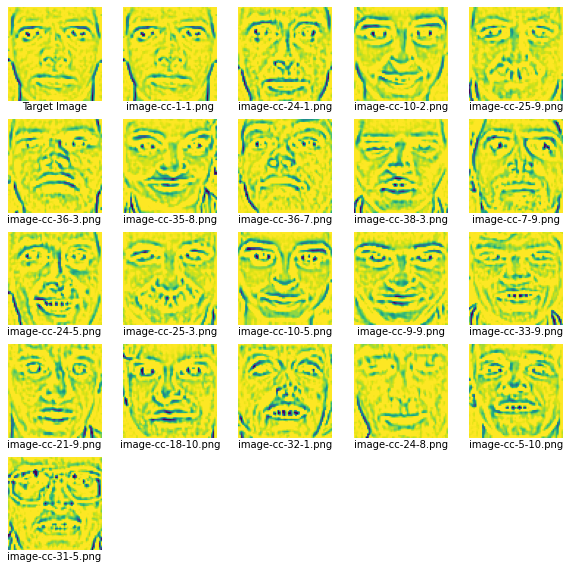

In [ ]:
plot_results_task5(similar_images, 'test/'+query_image_id)

Accuracy for X:  1.0
Misses for X:  0
Overall accuracy:  1.0
Accuracy:  [1.] 

False positive rate (Fall out): [nan] 

False negative rate (Miss rate): [0.] 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


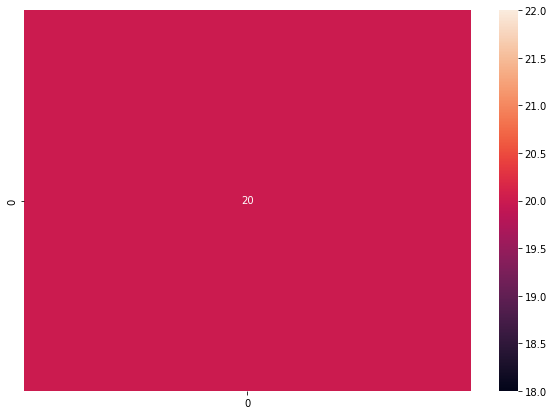

In [ ]:
actual = [1] * len(similar_images)
predicted = []
for similar_image in similar_images:
  if (similar_image.split('-')[1] == query_image_id.split('-')[1]):
    predicted.append(1)
  else:
    predicted.append(0)

print("Accuracy for X: ", predicted.count(1)/len(predicted))
print("Misses for X: ", predicted.count(0))

extraa(actual, predicted)

#Task 6
 Implement a decision tree based relevance feedback system to improve nearest neighbor matches, which enables the user to label some of the results returned by the search task as relevant
or irrelevant and then returns a new set of ranked results, either by revising the query or by re-ordering the existing results.

In [ ]:
def create_data_for_classifier(relevancy_map, search_results):
        X = []
        y = []
        for result in search_results:
            relevancy = relevancy_map.get(result['imageName'], -1)
            if relevancy == 0 or relevancy == 1:
                X.append(result['feature_vector'])
                y.append(relevancy)
        return np.array(X), np.array(y)

In [ ]:
def Task6(search_results, relevancy_map):
    DT = DecisionTreeClassifier(max_depth=100)
    X, y = create_data_for_classifier(relevancy_map, search_results)
    DT.fit(X, y)
    
    for result in search_results:
        if relevancy_map[result['imageName']] == -1:
            input_vector = result['feature_vector']
            prediction = DT.predict([input_vector])
            relevancy_map[result['imageName']] = prediction[0]
            
    
    ordered_search_results = sorted(search_results, key=lambda d: d['distance_score'])
    
    final_result = []
    for result in ordered_search_results:
        if relevancy_map[result['imageName']] == 1:
            final_result.append(result)
            print(result['imageName'], "Relevant")
    for result in ordered_search_results:
        if relevancy_map[result['imageName']] == 0:
            final_result.append(result)
            print(result['imageName'], "Irrelavant")
    
    return final_result

#Task 7
Implement an SVM based relevance feedback system to improve
nearest neighbor matches, which enables the user to label some of the results returned by the search task as relevant or
irrelevant and then returns a new set of ranked results, either by revising the query or by re-ordering the existing results.

In [ ]:
def Task7(search_results, relevancy_map):
    svm = MulticlassSVM(C=0.1, tol=0.01, max_iter=100, random_state=0, verbose=1)
    X, y = create_data_for_classifier(relevancy_map, search_results)
    svm.fit(X, y)
    
    for result in search_results:
        if relevancy_map[result['imageName']] == -1:
            input_vector = result['feature_vector']
            prediction = svm.predict([input_vector])
            if prediction[0] == -1:
                relevancy_map[result['imageName']] = 0
            elif prediction[0] == 1:
                relevancy_map[result['imageName']] = 1
                
    ordered_search_results = sorted(search_results, key=lambda d: d['distance_score'])
    
    final_result = []
    for result in ordered_search_results:
        if relevancy_map[result['imageName']] == 1:
            final_result.append(result)
            print(result['imageName'], "Relevant")
    for result in ordered_search_results:
        if relevancy_map[result['imageName']] == 0:
            final_result.append(result)
            print(result['imageName'], "Irrelavant")
    return final_result

#Task 8
Implement a query interface, which allows the user to provide a query, relevant
query parameters (including how many results to be returned). Query results are presented to the user in decreasing order
of matching.
The result interface should also allow to user to provide positive and/or negative feedback for the ranked results returned
by the system.
User feedback is than taken into account (either by revising the query or by re-ordering the results as appropriate) and a
new set of ranked results are returned.

In [ ]:
def Task8():
    
    task = int(input("\n1.LSH\n2.VA Files\n"))
    query_image = input("Input query image name: ")
    num_results = int(input("Enter number of results for query: "))
    if task == 1:       
        points_dict, w_length, config, train_folder, image_features, reduced_data, reduced_dict, v_matrix = Task4a(int(input('Number of layers: ')), int(input('Number of Hashes: ')), 'train', 'HOG')
        similar_images, query_image_id = Task4b(num_results, query_image, points_dict, w_length, config, train_folder, image_features, reduced_data, reduced_dict, v_matrix)
    elif task == 2:
        temp, similar_images = Task5b('test/'+query_image,'HOG', num_results)
    else:
        pass

    r_count = int(input('Number of Relevant Images?:'))
    ir_count = int(input('Number of Irrelevant Images?:'))
    
    num_to_image = {}
    count = 1
    relevancy_map = {}
    for image in similar_images:
        num_to_image[count] = image['imageName']
        print(count, image['imageName'])
        relevancy_map[image['imageName']] = -1
        count += 1
    
    count=0
    print("\n\n")
    while r_count > 0:
        index = int(input('Relevant Image Number?: '))
        r_count -= 1
        relevancy_map[num_to_image[index]] = 1
    while ir_count > 0:
        index = int(input('Irrelevant Image Number?: '))
        ir_count -= 1
        relevancy_map[num_to_image[index]] = 0

    classifier = int(input("\nClassifier\n1. Decision Tree\n2. SVM\n"))
    if classifier == 1:
        result = Task6(similar_images, relevancy_map)
    if classifier == 2:
        result = Task7(similar_images, relevancy_map)

Task8()


1.LSH
2.VA Files
1
Input query image name: image-cc-1-1.png
Enter number of results for query: 20
Number of layers: 15
Number of Hashes: 15
Initializing LSH index with 15 Layers and 15 Hashes
Grouping data into buckets
          0         1         2    ...       253       254       255
0   -6.163162  0.358957  0.263837  ...  0.011600 -0.091758  0.098492
1   -6.148445  0.710235  0.739198  ... -0.092085  0.015751  0.291075
2   -5.139398  0.564551  2.231425  ...  0.016288  0.127344 -0.059825
3   -5.014546 -3.704459  0.550343  ... -0.027033  0.095299 -0.109770
4   -5.960274  0.880382  0.311147  ...  0.015702  0.029196 -0.011018
..        ...       ...       ...  ...       ...       ...       ...
775 -5.703477  1.093711 -0.637188  ...  0.011840 -0.047130  0.069961
776 -6.033749  0.382763  0.371418  ... -0.112693 -0.021246  0.028218
777 -5.950293  0.351760  0.839996  ... -0.070365  0.277328 -0.017291
778 -5.755367  1.107785  0.228097  ...  0.126667  0.056647  0.220757
779 -5.189057 -3.9736

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Initializing LSH index with 15 Layers and 15 Hashes
Hash Key List ['50-46-52-45-47-42-39-54-46-51-47-41-44-48-59', '38-41-52-41-54-58-48-55-47-41-42-44-49-52-51', '38-29-54-45-44-51-40-50-40-36-49-53-45-54-55', '41-37-52-44-36-33-45-50-57-50-40-50-54-46-53', '49-45-42-47-49-47-55-43-30-33-55-36-49-49-46', '57-54-45-50-48-50-41-48-58-35-42-40-50-31-52', '50-58-44-49-44-48-43-51-52-43-48-46-41-54-37', '42-49-43-35-42-40-53-48-45-43-53-53-38-44-52', '35-59-37-56-54-49-56-48-53-44-55-57-51-40-54', '44-43-45-38-41-41-49-48-37-47-33-53-39-51-44', '51-49-40-47-55-42-45-45-39-41-54-36-54-43-54', '53-44-49-50-51-47-51-33-48-46-48-37-40-40-46', '49-54-51-41-50-46-52-52-49-46-38-50-46-57-44', '50-49-41-44-53-50-60-59-43-51-55-46-51-49-41', '52-44-44-52-58-45-35-47-45-49-44-45-49-47-48']
Getting bucket - 50-46-52-45-47-42-39-54-46-51-47-41-44-48-59
Getting bucket - 38-41-52-41-54-58-48-55-47-41-42-44-49-52-51
Getting bucket - 38-29-54-45-44-51-40-50-40-36-49-53-45-54-55
Getting bucket - 41-37-52-4